## Sampling for the Match Filter

In [1]:
#Libraries to import
using SerialPorts
using PyPlot
using FFTW 
list_serialports()

33-element Array{String,1}:
 "/dev/ttyACM1"
 "/dev/ttyS0"  
 "/dev/ttyS1"  
 "/dev/ttyS10" 
 "/dev/ttyS11" 
 "/dev/ttyS12" 
 "/dev/ttyS13" 
 "/dev/ttyS14" 
 "/dev/ttyS15" 
 "/dev/ttyS16" 
 "/dev/ttyS17" 
 "/dev/ttyS18" 
 "/dev/ttyS19" 
 ⋮             
 "/dev/ttyS27" 
 "/dev/ttyS28" 
 "/dev/ttyS29" 
 "/dev/ttyS3"  
 "/dev/ttyS30" 
 "/dev/ttyS31" 
 "/dev/ttyS4"  
 "/dev/ttyS5"  
 "/dev/ttyS6"  
 "/dev/ttyS7"  
 "/dev/ttyS8"  
 "/dev/ttyS9"  

In [2]:
a = []
i = 0
b = ""

ser = SerialPort("/dev/ttyACM1", 9600) 

r = readavailable(ser)

# Start a conversion
write(ser, "c")

while bytesavailable(ser) < 1
    continue 
end
sleep(0.05)
r = readavailable(ser)

# Get the values
write(ser, "p") # Print DMA buffer
while bytesavailable(ser) < 1
    continue # wait for a response
end

while true
    if bytesavailable(ser) < 2
        sleep(0.005) # Wait and check again
        if bytesavailable(ser) < 1
            break
        end
    end

    b = string(b, readavailable(ser))

end 

close(ser)

a=split(b, ("\r\n"))

println(length(a))   


30001


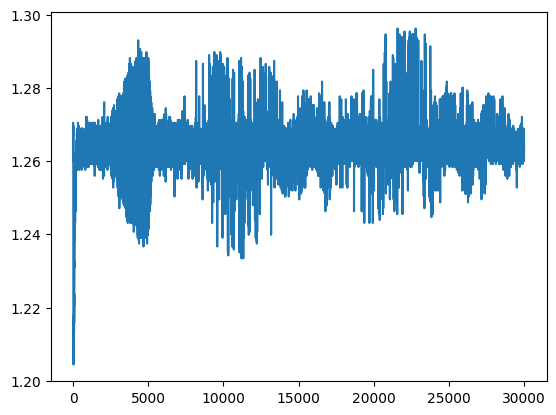

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fac3e04a978>

In [11]:
ac = []
i=1

while (i<length(a))
 
        push!(ac,parse(Int,(a[i])))        
#     end 
    i+=1
end

match = (3.3/4096).*ac

figure()
plot(match)

## Sampling the Echo 

In [12]:
list_serialports() # show available ports

y = []
b = ""
i = 0

# ser = SerialPort("COM3:", 9600) 
ser = SerialPort("/dev/ttyACM1", 9600) 

r = readavailable(ser)

# Start a conversion
write(ser, "c")

while bytesavailable(ser) < 1
    continue 
end
sleep(0.05)
r = readavailable(ser)

# Get the values
write(ser, "p") # Print DMA buffer
while bytesavailable(ser) < 1
    continue # wait for a response
end

while true
    if bytesavailable(ser) < 2
        sleep(0.005) # Wait and check again
        if bytesavailable(ser) < 1
            break
        end
    end

    b = string(b, readavailable(ser))

end 

close(ser)

y=split(b, ("\r\n"))

println(length(y))   


30001


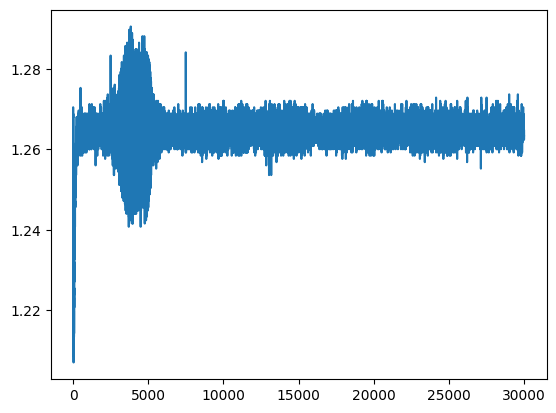

30000


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fac2df65240>

In [13]:
rc = []
i=1

while (i<length(y))

    push!(rc,parse(Int,(y[i])))        

    i+=1
end


receive = (3.3/4096).*rc
println(length(rc))   
# print(match)
figure()
plot(receive)


### Values for Processing

In [14]:
c = 343;          # Speed of sound in air in m/s
fs = 500000;       # This is the sample rate of the sonar.
dt = 1/fs;        # This is the sample spacing
r_max = 11;        # Maximum range in metres to which to simulate.
t_max = 2*r_max/c;

t = collect(0:dt:t_max);

r = c*t/2;        

f0 = 40000;       # Centre frequency is 10 kHz
B = 2000;         # Chirp bandwidth
T = 6E-3;         # Chirp pulse length
K = B/T;          # Chirp rate

td = 0.6*T;

## Matched Filtering

In [15]:
N = length(t);
Δf = 1/(N*dt)  
# spacing in frequency domain

#create array of freq values stored in f_axis. First element maps to 0Hz
f_axis = (0:N-1)*Δf; 
print(N)

32070

In [16]:
for i = 30001:N
    push!(match,match[30000])
    push!(receive,receive[30000])
end

In [17]:
v_tx = match #the matched filter will be the 
V_TX = fft(v_tx);

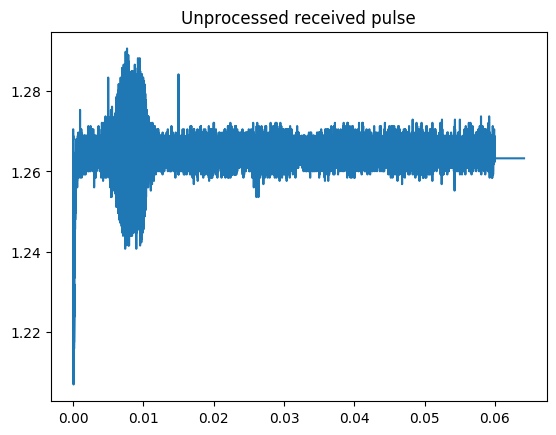

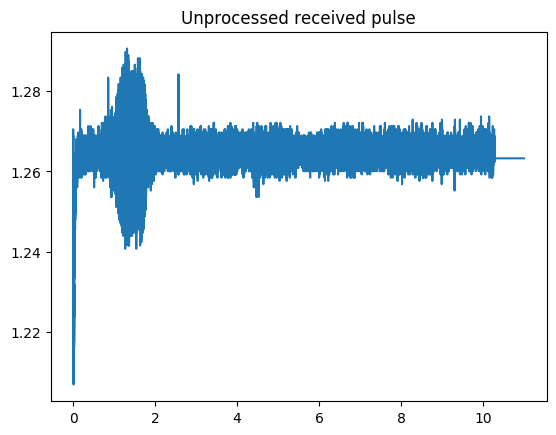

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fac2e020668>

In [18]:
v_rx = receive

figure() # Create a new figure
title("Unprocessed received pulse")
plot(t,v_rx) # Basic plot, axis labeled in samples

figure() # Create a new figure
title("Unprocessed received pulse")
plot(r,v_rx) # Basic plot, axis labeled in samples

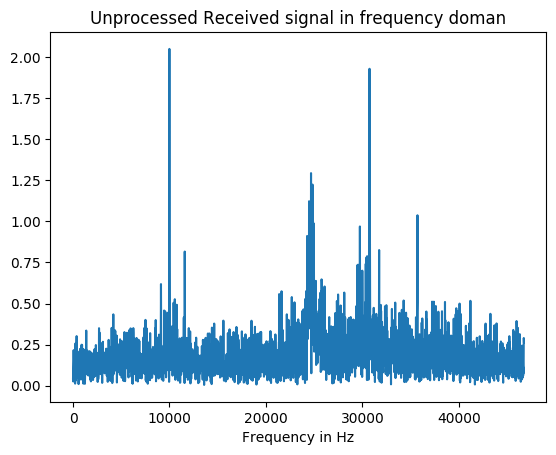

In [19]:
V_RX = (fft(v_rx));

figure("Unprocessed Received signal in frequency doman")
plot(f_axis[1:3000],abs.(fftshift(V_RX))[1:3000] )
title("Unprocessed Received signal in frequency doman")
xlabel("Frequency in Hz");

## Matched Signal

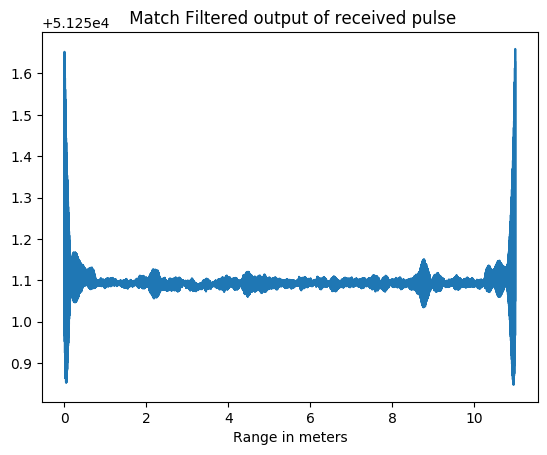

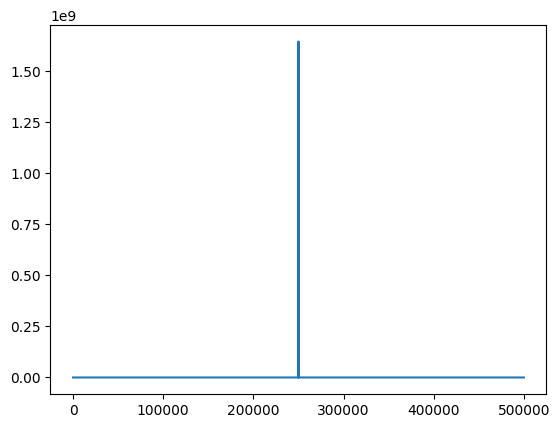

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fac2dee1e80>

In [20]:
H = conj( V_TX);

V_MF = H.*V_RX;
v_mf = ifft(V_MF);

figure() # Create a new figure
xlabel("Range in meters")
title(" Match Filtered output of received pulse")
plot(r, v_mf) # Basic plot, axis labeled in samples

figure()
plot(f_axis,abs.(fftshift(V_MF)) )

In [21]:
V_ANAL = 2*V_MF; # make a copy and double the values
N = length(V_MF);

V_ANAL = 2*V_MF; # make a copy and double the values

N = length(V_MF);

if mod(N,2)==0 # case N even
    neg_freq_range = Int(N/2):N; # Define range of “neg-freq” components
else # case N odd
    neg_freq_range = Int((N+1)/2):N;
end

V_ANAL[neg_freq_range] .= 0; # Zero out neg components in 2nd half of array.
v_anal = ifft(V_ANAL);

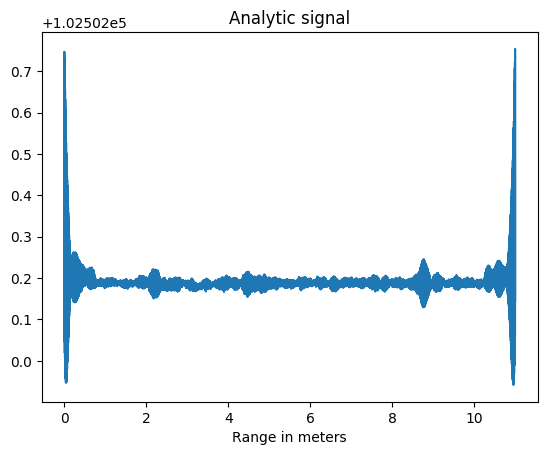

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fac2ddd3f60>

In [22]:
figure()
title("Analytic signal")
xlabel("Range in meters")
plot(r,abs.(v_anal))

In [23]:
j=im; # Assign j as sqrt(-1) (“im” in julia)
v_bb = v_anal.*exp.(-j*2*pi*f0.*t);

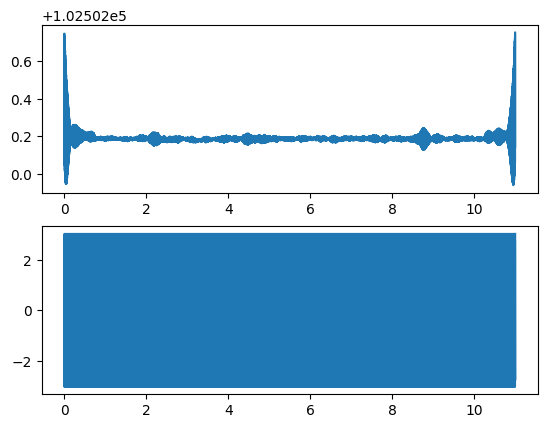

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fac2de9fa20>

In [24]:
figure()
subplot(2,1,1)
plot(r,abs.(v_bb))
subplot(2,1,2)
plot(r,angle.(v_bb)) #query

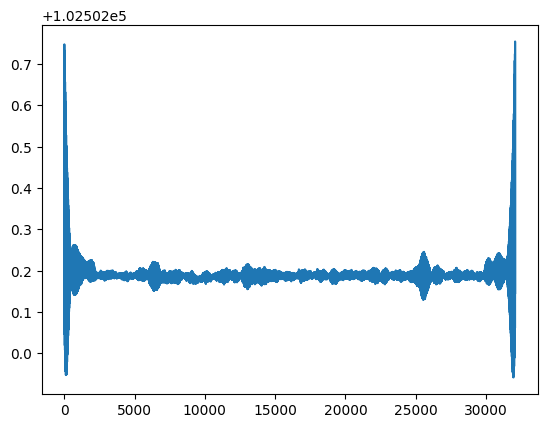

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fac2b9c12b0>

In [25]:
V_BB = fft(v_bb); 
figure()
plot(abs.(v_bb))

In [ ]:
close(ser)